In [65]:
class Infix:
    def __init__(self, function):
        self.function = function
    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))
    def __or__(self, other):
        return self.function(other)
    def __call__(self, value1, value2):
        return self.function(value1, value2)

In [66]:
from dolfinx import fem, mesh, plot
from ufl import dx, ds, grad, inner, exp, sin
import ufl

import numpy as np
import math
import matplotlib.pyplot as plt

from mpi4py import MPI
from dolfinx import io

In [67]:
dot= Infix(inner)

In [68]:
domain_mesh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                                    points=((0, 0), (2, 3)),
                                    n=(10, 10),
                                    cell_type=mesh.CellType.triangle)
space = fem.FunctionSpace(domain_mesh, ('Lagrange', 1))

In [69]:
markers_bc = mesh.locate_entities_boundary(
    domain_mesh,
    dim=1,
    marker=lambda x: np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], 2.0))
    )

dofs_bc = fem.locate_dofs_topological(V=space, entities=markers_bc, entity_dim=1)
bc = fem.dirichletbc(V=space, value=np.float64(0), dofs=dofs_bc)


In [80]:
u = ufl.TrialFunction(space)
v = ufl.TestFunction(space)
x = ufl.SpatialCoordinate(domain_mesh)

f = 10 * exp(-((x[0] - 0.5)**2 + (x[1] - 0.5)**2) / 0.02)
g = sin(5 * x[0])

# f0_expression= lambda x: 10 * math.exp(-((x[0] - 0.5)**2 + (x[1] - 0.5)**2) / 0.02)
# f0_expression= lambda y: 10 * -math.exp((y[0] - 0.5)**2 + (y[1] - 0.5)**2) / 0.02
# f0 = fem.Function(space)
# f0.interpolate(f0_expression)

r = (grad(u) |dot| grad(v)) * dx
a = inner(grad(u), grad(v)) * dx

l = (f |dot| v) * dx + (g |dot| v) * ds
L = inner(f, v) * dx + inner(g, v) * ds

problem = fem.petsc.LinearProblem(r,l,
                                  bcs=[bc],
                                  petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
u_sol=problem.solve()

In [ ]:
topology,types,geometry = plot.create_vtk_mesh(space)
u_topology = u_sol.x.array
data = np.column_stack((geometry[:,0:2],u_topology))

In [ ]:
len(data)

121

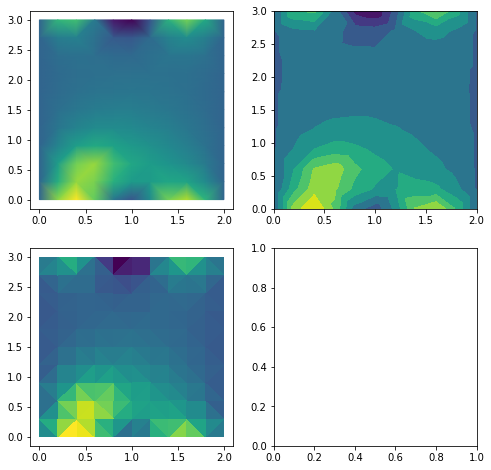

In [94]:
x_data= data[:,0]
y_data=data[:,1]
z_data=data[:,2]

levels = np.linspace(z_data.min(), z_data.max(), 10)
fig, ax = plt.subplots(2,2,figsize=(8,8))

ax[0,0].tripcolor(x_data, y_data, z_data,shading='gouraud')
ax[0,1].tricontourf(x_data, y_data, z_data, levels=levels)
ax[1,0].tripcolor(x_data, y_data, z_data,shading='flat')